# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from importlib import reload

# os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project/Kha Huynh')
import utils
reload(utils)
import load_parquet as load_df
reload(load_df)
import gpt_utils as gpt_utils
reload(gpt_utils)

np.warnings = warnings
# os.chdir('D:/Kha/UWA/CITS5553/sepsis_prediction/data-science-capstone-project')

ROOT_DIR = Path('../..')

# 1.Dataset Processing

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [3]:
# load transaction dataset
df_patients = pd.read_csv(ROOT_DIR / 'data\PATIENTS.csv')
df_admissions = pd.read_csv(ROOT_DIR / 'data\ADMISSIONS.csv')
df_diagnoses_icd = pd.read_csv(ROOT_DIR / 'data\DIAGNOSES_ICD.csv')
df_labevents = pd.read_csv(ROOT_DIR / 'data\LABEVENTS.csv')
# df_labevents = pd.read_csv(ROOT_DIR / 'data\labevents_cleaned.csv')
# df_labevents = pd.read_csv(ROOT_DIR / 'data/output_csv/labevents_with_time.csv')
df_microbiologyevents = pd.read_csv(ROOT_DIR / 'data\MICROBIOLOGYEVENTS.csv')

# load description tables
df_desc_icd = pd.read_csv(ROOT_DIR / 'data\D_ICD_DIAGNOSES.csv')
df_desc_labitems = pd.read_csv(ROOT_DIR / 'data\D_LABITEMS.csv')
df_desc_items = pd.read_csv(ROOT_DIR / 'data\D_ITEMS.csv')

In [3]:
df_labevents = pd.read_csv(ROOT_DIR / 'data\LABEVENTS.csv')

In [4]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDREGTIME'] = pd.to_datetime(df_admissions['EDREGTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['EDOUTTIME'] = pd.to_datetime(df_admissions['EDOUTTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
# df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [58]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'seps' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [79]:
try:
    df_demographic = pd.read_csv(ROOT_DIR / 'data/demographic.csv')
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = (((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: utils.check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)
    utils.save_csv(df_demographic, ROOT_DIR / 'data/demographic.csv')
# convert admittime and dischtime to datetime
df_demographic['ADMITTIME'] = pd.to_datetime(df_demographic['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic['DISCHTIME'] = pd.to_datetime(df_demographic['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

there are 5406 admissions has IS_SEPSIS=1.

But in the df_diagnoses_icd has 5409. The code below found that 3 HADM_ID is diagnosed sespsis 2 twice (with the same/different sepsis icd9_code)

In [ ]:
# there are 3 HADM_ID are predicted sepsis twice in diagnoses table
df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'][df_diagnoses_icd[df_diagnoses_icd['IS_SEPSIS'] == 1]['HADM_ID'].duplicated()]

27720     124907
410048    124482
639237    107047
Name: HADM_ID, dtype: int64

#### Inspect age range

Plotting the boxplot of age between admissions sepsis and non-sepsis below found that older people is likely to have sepsis than the young.

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

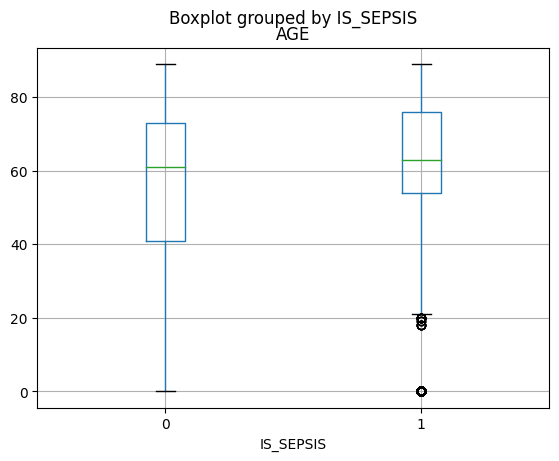

In [ ]:
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

Looking at the boxplot we see some outliers in the age feature, some patients around 300 years old.

In [ ]:
a = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())
b = len(df_demographic[df_demographic.AGE>100]['SUBJECT_ID'].unique())/len(df_demographic['SUBJECT_ID'].unique())*100
print('The number of patients aged over 100 years old is: {} patients ({:.2f}% over all patients)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)]['SUBJECT_ID'].unique())/len(df_demographic[df_demographic.IS_SEPSIS==1]['SUBJECT_ID'].unique())*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

a = len(df_demographic[df_demographic.AGE>100])
b = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(a,b))

a = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])
b = len(df_demographic[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS==1)])/len(df_demographic[df_demographic.IS_SEPSIS==1])*100
print('- {} of them has sepsis ({:.2f}% over all sepsis patients)'.format(a,b))

The number of patients aged over 100 years old is: 1991 patients (4.28% over all patients)
- 345 of them has sepsis (7.22% over all sepsis patients)
The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
- 389 of them has sepsis (7.20% over all sepsis patients)


In [ ]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))
df_demographic.loc[df_demographic.AGE>100, 'AGE'] = median_age

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


### Labevents Cleanup empty HADM_ID

In [54]:
# get all labevent records with HADM_ID null and merge with the demographic table to have the HADM_ID, ADMITTIME, DISCHTIME
df_empty_hadm_labevents = df_labevents[df_labevents['HADM_ID'].isnull()]
df_empty_hadm_labevents = df_empty_hadm_labevents.merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], on='SUBJECT_ID')

# only keep records that has ADMITTIME <= CHARTTIME <= DISCHTIME and remove other records
index = df_empty_hadm_labevents[(df_empty_hadm_labevents['CHARTTIME'] >= df_empty_hadm_labevents['ADMITTIME']) & (df_empty_hadm_labevents['CHARTTIME'] <= df_empty_hadm_labevents['DISCHTIME'])].index
df_empty_hadm_labevents = df_empty_hadm_labevents[df_empty_hadm_labevents.index.isin(index)]
# set the HADM_ID of the labevents with HADM_ID of the demographic table
df_empty_hadm_labevents.HADM_ID_x = df_empty_hadm_labevents.HADM_ID_y

# Rename HADM_ID_x to HADM_ID and remove HADM_ID_y, ADMITTIME, DISCHTIME columns
df_empty_hadm_labevents.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)
df_empty_hadm_labevents.drop(columns=['HADM_ID_y', 'ADMITTIME', 'DISCHTIME'], inplace=True)

# concat the updated records with records that originally have HADM_ID
df_not_empty_hadm = df_labevents[~df_labevents.HADM_ID.isnull()]
combined_df_hasHADM = pd.concat([df_not_empty_hadm, df_empty_hadm_labevents], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)
df_labevents = combined_df_hasHADM

In [ ]:
utils.save_csv(df_labevents, ROOT_DIR / 'data/labevents_cleaned.csv')

### draft

In [ ]:
analysis = sv.analyze(df_patient)

In [ ]:
analysis.show_notebook()

In [ ]:
df_labevents_processed = load_df.load_labevents_dask(ROOT_DIR)

2023-09-06 10:34:54.416082 Start
2023-09-06 10:34:54.858413 2045381
2023-09-06 10:34:57.505488 End


## 1.2 Data Exploration

### GPT

In [ ]:
prompt = '''
[INST]
You are a medical expert. You are tasked to identify causality between two conditions.
Return yes if A causes B and the rank for causality. If B causes A or if you are not sure, return no. Keep your responses short and succinct.
[/SYS]
Input
{test}
[/INST]
'''
gpt_utils.run(prompt,"A: blood; B: sepsis")
# gpt_utils.chat_with_chatgpt(prompt, "A: White blood cells")

In [ ]:
dup_rowid = df_desc_labitems[df_desc_labitems.LABEL.duplicated(keep=False) == True]['ROW_ID'].unique()
df_desc_labitems['FULL_LABEL'] = df_desc_labitems.apply(lambda x: x.LABEL if x['ROW_ID'] not in dup_rowid else f"{x.LABEL} in {x.FLUID} of {x.CATEGORY}", axis=1)

In [ ]:
# events = pd.concat([df_desc_labitems[~df_desc_labitems.ROW_ID.isin(dup_rowid)]['LABEL'],
#            df_desc_labitems[df_desc_labitems.ROW_ID.isin(dup_rowid)].apply(lambda x: f"{x.LABEL} in {x.FLUID} of {x.CATEGORY}", axis=1)],
#           ignore_index=True)

# df = pd.DataFrame(data=events, columns=['event'])
df_desc_labitems['relation'] = df_desc_labitems.apply(lambda x: gpt_utils.run(prompt, f"A: {x.FULL_LABEL}, B: sepsis"), axis=1)
df_desc_labitems['result'] = df_desc_labitems.apply(lambda x: 'Yes' if 'Yes' in x.relation else 'No', axis=1)
utils.save_csv(df_desc_labitems, ROOT_DIR / 'data/labevents_gpt.csv')

### Time distribution of a patient's first lab event since admission

In [ ]:
df_labevents = df_labevents.sort_values(['HADM_ID', 'CHARTTIME'])
first_labevents = df_labevents.drop_duplicates(['SUBJECT_ID', 'HADM_ID'], keep='first')[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']]
first_labevent_time = df_demographic[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS', 'ADMISSION_LOCATION']].merge(first_labevents, on=['SUBJECT_ID', 'HADM_ID'])

first_labevent_time.ADMITTIME = pd.to_datetime(first_labevent_time['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
first_labevent_time.CHARTTIME = pd.to_datetime(first_labevent_time['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

first_labevent_time['TIME'] = np.where(first_labevent_time.CHARTTIME > first_labevent_time.ADMITTIME,
                      np.ceil((first_labevent_time.CHARTTIME - first_labevent_time.ADMITTIME).dt.total_seconds() / 3600),
                      np.floor((first_labevent_time.CHARTTIME - first_labevent_time.ADMITTIME).dt.total_seconds() / 3600))

In [ ]:
len(first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time)

0.9308661498530347

In [ ]:
len((first_labevent_time[first_labevent_time.IS_SEPSIS==1])[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time[first_labevent_time.IS_SEPSIS==1])

C:\Users\vicky\AppData\Local\Temp\ipykernel_3380\2062131203.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len((first_labevent_time[first_labevent_time.IS_SEPSIS==1])[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10)])/len(first_labevent_time[first_labevent_time.IS_SEPSIS==1])


0.960577456968351

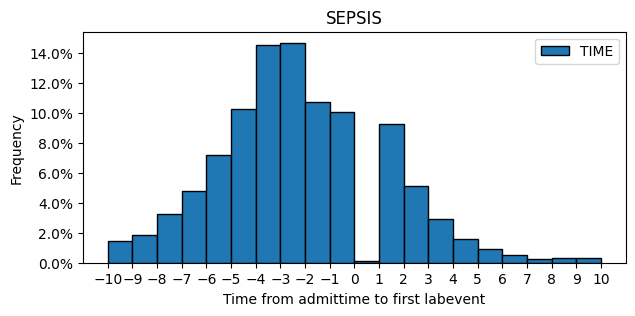

In [ ]:
sepsis_have_labvents_in10h = first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10) & (first_labevent_time.IS_SEPSIS==1)]
sepsis_have_labvents_in10h.\
  plot(kind='hist', y='TIME', bins=20, \
       weights=np.ones(len(sepsis_have_labvents_in10h)) / len(sepsis_have_labvents_in10h),\
       xticks=list(range(-10, 11)), \
       edgecolor='black', title='SEPSIS', xlabel='Time from admittime to first labevent', figsize=(7, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
step = 1
bin_range = np.arange(-10, 10+step, step)
out, bins  = pd.cut(sepsis_have_labvents_in10h['TIME'], bins=bin_range, include_lowest=True, right=False, retbins=True)

<Axes: xlabel='TIME'>

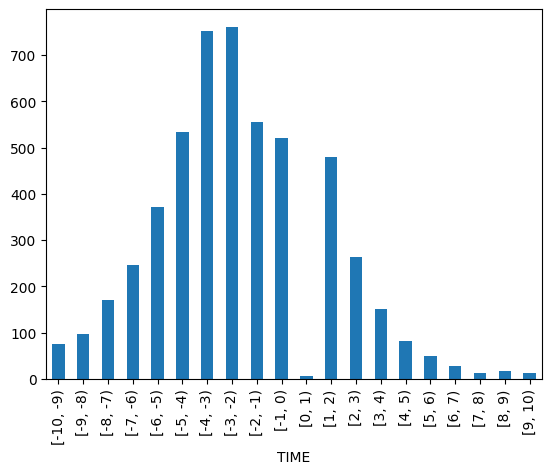

In [ ]:
out.value_counts().sort_index().plot.bar()

<Axes: xlabel='ADMISSION_LOCATION'>

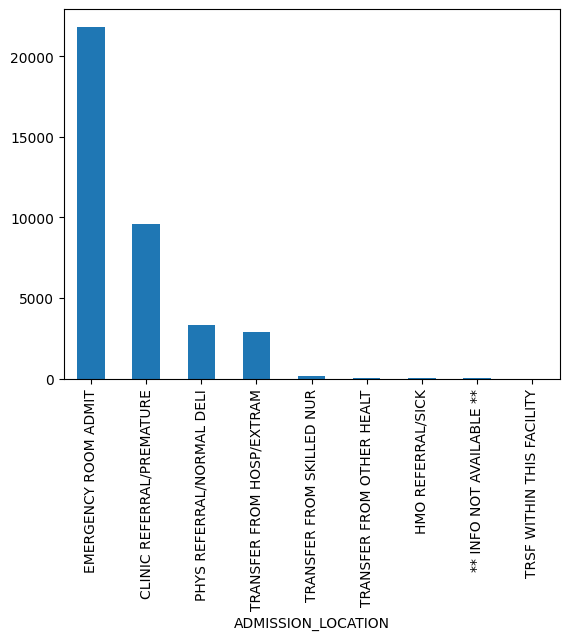

In [ ]:
first_labevent_time[first_labevent_time.TIME<0]['ADMISSION_LOCATION'].value_counts().plot(kind='bar')

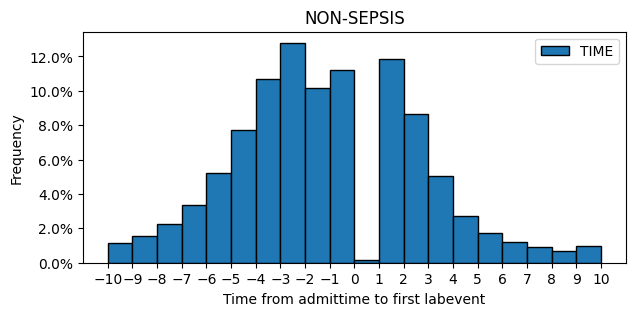

In [ ]:
nonsepsis_have_labvents_in10h = first_labevent_time[(first_labevent_time.TIME <= 10) & (first_labevent_time.TIME >= -10) & (first_labevent_time.IS_SEPSIS==0)]
nonsepsis_have_labvents_in10h.\
  plot(kind='hist', y='TIME', bins=20, \
       weights=np.ones(len(nonsepsis_have_labvents_in10h)) / len(nonsepsis_have_labvents_in10h),\
       xticks=list(range(-10, 11)), \
       edgecolor='black', title='NON-SEPSIS', xlabel='Time from admittime to first labevent', figsize=(7, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

### Top 10 common labvents tested for sepsis patient

In [ ]:
from collections import Counter
import datetime

def compute_common_test(x, hours=-99):
  x = x.sort_values(['CHARTTIME'])
  if hours <= 0:
    return x['ITEMID'].unique()
  else:
    target_time = x.iloc[0]['CHARTTIME'] + pd.DateOffset(hours=hours)
    return x[x.CHARTTIME <= target_time]['ITEMID'].unique()

def get_top_common_labevents(hours, top_n, IS_SEPSIS=1):
  labevents_with_issepsis = df_labevents.merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']], on=['SUBJECT_ID', 'HADM_ID'])
  item_list = labevents_with_issepsis[labevents_with_issepsis.IS_SEPSIS==IS_SEPSIS].groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: compute_common_test(x, hours))
  all_itemid = [itemid for sublist in item_list.values for itemid in sublist]
  value_counts = Counter(all_itemid).most_common(top_n)

  most_common_test_for_sepsis = pd.DataFrame({'ITEMID': [item[0] for item in value_counts],\
                                              'LABEL': df_desc_labitems[df_desc_labitems.ITEMID.isin([item[0] for item in value_counts])]['LABEL'],\
                                                'COUNT': [item[1] for item in value_counts]})
  return most_common_test_for_sepsis

In [ ]:
get_top_common_labevents(hours=4, top_n=15, IS_SEPSIS=1)

,ITEMID,LABEL,COUNT
209,51221,Bicarbonate,5181
229,51301,Chloride,5155
239,51265,Creatinine,5142
298,51222,Potassium,5136
310,51249,Sodium,5135
332,51250,Urea Nitrogen,5135
547,51279,Hematocrit,5135
548,51248,Hemoglobin,5135
574,51277,MCH,5130
575,50912,MCHC,4939


## 1.3 Feature Selection

In [76]:
def get_admittime(x):
  x = x.sort_values(['CHARTTIME'])
  min_charttime = x.iloc[0]['CHARTTIME']
  new_admittime = x.iloc[0].ADMITTIME
  if min_charttime < new_admittime:
    new_admittime = min_charttime
  return new_admittime

def create_potential_events_file(potential_icd9_code_file, hours=10):
  potential_icd9_code = pd.read_csv(potential_icd9_code_file)
  potential_icd9_code['ICD9_CODE'] = potential_icd9_code['ICD9_CODE'].str.replace('"', '')
  
  potential_cases = df_diagnoses_icd[df_diagnoses_icd.ICD9_CODE.isin(potential_icd9_code.ICD9_CODE)][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].drop_duplicates(['SUBJECT_ID', 'HADM_ID'])
  # potential_cases = df_demographic[df_demographic.IS_SEPSIS==1][['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS']].merge(potential_cases[['SUBJECT_ID', 'HADM_ID']])
  potential_cases = df_demographic[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS']].merge(potential_cases[['SUBJECT_ID', 'HADM_ID']])
  potential_cases = df_labevents.merge(potential_cases, on=['SUBJECT_ID', 'HADM_ID'])[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'ADMITTIME', 'CHARTTIME', 'FLAG']]
  
  new_admittime = potential_cases.groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: get_admittime(x)).reset_index(name='NEW_ADMITTIME')
  potential_cases = potential_cases.merge(new_admittime, on=['SUBJECT_ID', 'HADM_ID'])

  potential_cases['TIME'] = np.ceil((potential_cases.CHARTTIME - potential_cases.NEW_ADMITTIME).dt.total_seconds() / 3600)
  potential_cases = potential_cases[(potential_cases.TIME <= hours)]
  potential_cases = potential_cases.merge(df_desc_labitems[['ITEMID', 'LABEL', 'FLUID']], on=['ITEMID'])

  out_file_abnormal = ROOT_DIR / 'data/output_csv/potential_events_abnormal.csv'
  out_file_others = ROOT_DIR / 'data/output_csv/potential_events_others.csv'
  utils.save_csv(potential_cases[potential_cases.FLAG == 'abnormal'], out_file_abnormal)
  utils.save_csv(potential_cases[potential_cases.FLAG != 'abnormal'], out_file_others)
  return [out_file_abnormal, out_file_others]

In [75]:
pd.read_csv(ROOT_DIR / 'data/output_csv/potential_events_others.csv')

C:\Users\vicky\AppData\Local\Temp\ipykernel_17312\1507216508.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(ROOT_DIR / 'data/output_csv/potential_events_others.csv')


,SUBJECT_ID,HADM_ID,ITEMID,ADMITTIME,CHARTTIME,FLAG,NEW_ADMITTIME,TIME,LABEL,FLUID
0,3,145834,50868,2101-10-20 19:08:00,2101-10-20 16:40:00,NaN,2101-10-20 16:40:00,0.0,Anion Gap,Blood
1,3,145834,50868,2101-10-20 19:08:00,2101-10-22 04:00:00,NaN,2101-10-20 16:40:00,36.0,Anion Gap,Blood
2,3,145834,50868,2101-10-20 19:08:00,2101-10-21 03:00:00,NaN,2101-10-20 16:40:00,11.0,Anion Gap,Blood
3,3,145834,50868,2101-10-20 19:08:00,2101-10-21 13:00:00,NaN,2101-10-20 16:40:00,21.0,Anion Gap,Blood
4,6,107064,50868,2175-05-30 07:15:00,2175-05-31 01:48:00,NaN,2175-05-30 07:15:00,19.0,Anion Gap,Blood
...,...,...,...,...,...,...,...,...,...,...
4550049,93360,187866,51175,2196-06-21 21:15:00,2196-06-23 01:35:00,NaN,2196-06-21 18:15:00,32.0,CD3 Absolute Count,Blood
4550050,93360,187866,51185,2196-06-21 21:15:00,2196-06-23 01:35:00,NaN,2196-06-21 18:15:00,32.0,CD5 %,Blood
4550051,93360,187866,51186,2196-06-21 21:15:00,2196-06-23 01:35:00,NaN,2196-06-21 18:15:00,32.0,CD5 Absolute Count,Blood
4550052,98453,111120,51153,2138-09-04 18:54:00,2138-09-06 10:31:00,NaN,2138-09-04 11:30:00,48.0,CD103,Blood


In [77]:
create_potential_events_file(ROOT_DIR / 'data/Top_50_Common_icds_with_all_kind_of_sepsis.csv')

[WindowsPath('../../data/output_csv/potential_events_abnormal.csv'),
 WindowsPath('../../data/output_csv/potential_events_others.csv')]

In [ ]:
df_diagnoses_icd[df_diagnoses_icd.duplicated(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'], keep=False)]

In [ ]:
sepsis_cases = df_diagnoses_icd[df_diagnoses_icd.IS_SEPSIS == 1].drop_duplicates(['SUBJECT_ID', 'HADM_ID'])[['SUBJECT_ID', 'HADM_ID']]
sepsis_cases = sepsis_cases.merge(df_diagnoses_icd[df_diagnoses_icd.IS_SEPSIS != 1][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']], on=['SUBJECT_ID', 'HADM_ID'])
sepsis_cases = sepsis_cases.merge(df_desc_icd[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE')
common_icd = sepsis_cases.groupby(['ICD9_CODE', 'SHORT_TITLE']).apply(lambda x: len(x.drop_duplicates(['SUBJECT_ID', 'HADM_ID']))).sort_values(ascending=False).reset_index(name='COUNT')
common_icd = common_icd.head(20)
utils.save_csv(common_icd, ROOT_DIR / 'data/potential_icd9.csv')

### Analyze delta t

In [ ]:
def get_admittime(x):
  x = x.sort_values(['CHARTTIME'])
  min_charttime = x.iloc[0]['CHARTTIME']
  new_admittime = x.iloc[0].ADMITTIME
  if min_charttime < new_admittime:
    new_admittime = min_charttime
  return new_admittime

def create_labevents_with_time(hours=48):
  potential_cases = df_labevents.merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'IS_SEPSIS']], on=['SUBJECT_ID', 'HADM_ID'])

  new_admittime = potential_cases.groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: get_admittime(x)).reset_index(name='NEW_ADMITTIME')
  potential_cases = potential_cases.merge(new_admittime, on=['SUBJECT_ID', 'HADM_ID'])

  potential_cases['TIME'] = np.ceil((potential_cases.CHARTTIME - potential_cases.NEW_ADMITTIME).dt.total_seconds() / 3600)
  potential_cases = potential_cases[(potential_cases.TIME <= hours)]
  potential_cases = potential_cases.merge(df_desc_labitems[['ITEMID', 'LABEL', 'FLUID']], on=['ITEMID'])

  out_file_abnormal = ROOT_DIR / 'data/output_csv/labevents_with_time.csv'
  utils.save_csv(potential_cases, out_file_abnormal)
  return potential_cases

a = create_labevents_with_time()

<Axes: xlabel='TIME'>

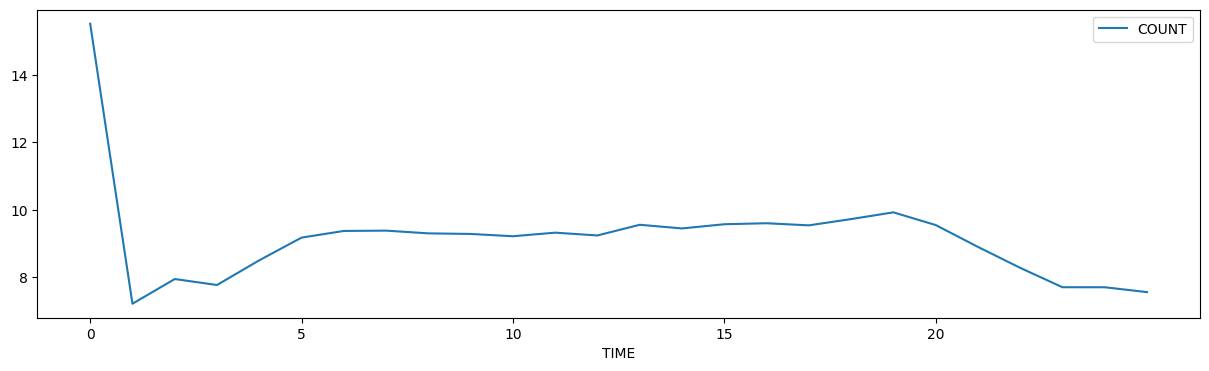

In [ ]:
df_chart = a[a.ITEMID.isin(pontential_events.ITEMID)].groupby(['TIME']).apply(lambda x: len(x)/len(x.HADM_ID.unique())).reset_index(name='COUNT')
df_chart[df_chart.TIME<=25].plot(kind='line', x='TIME', y='COUNT', xticks=list(range(0, 25,5)), figsize=(15,4))

<Axes: xlabel='TIME'>

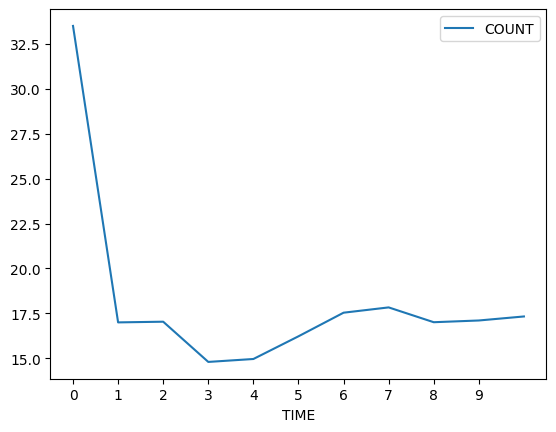

In [ ]:
df_chart = a[a.IS_SEPSIS==1].groupby(['TIME']).apply(lambda x: len(x)/len(x.HADM_ID.unique())).reset_index(name='COUNT')
df_chart[df_chart.TIME<=10].plot(kind='line', x='TIME', y='COUNT', xticks=list(range(0, 10)))

<Axes: xlabel='TIME'>

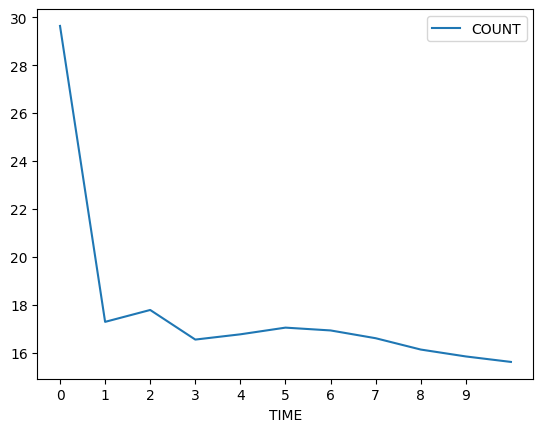

In [ ]:
df_chart = a.groupby(['TIME']).apply(lambda x: len(x)/len(x.HADM_ID.unique())).reset_index(name='COUNT')
df_chart[df_chart.TIME<=10].plot(kind='line', x='TIME', y='COUNT', xticks=list(range(0, 10)))

# Modelling

#### Create train data

In [6]:
def get_admittime(x):
  x = x.sort_values(['CHARTTIME'])
  min_charttime = x.iloc[0].CHARTTIME
  new_admittime = x.iloc[0].ADMITTIME
  if min_charttime < new_admittime:
    new_admittime = min_charttime
  return new_admittime

# load features from file and get top 10 features
pontential_events = pd.read_csv(ROOT_DIR / 'data/potential_events.csv')
# pontential_events['ITEMID'] = pontential_events['ITEMID'].str.replace('"', '')
feature_list = pontential_events.iloc[:10]['ITEMID']

# get all labevents rows filtered by itemid, t=n
def create_labevents_processed(hours=4):
  potential_cases = df_labevents[df_labevents.ITEMID.isin(feature_list)].merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'ADMITTIME', 'IS_SEPSIS']], on=['SUBJECT_ID', 'HADM_ID'])

  # if CHARTTIME < ADMITTIME => ADMITTIME = CHARTTIME
  new_admittime = potential_cases.groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: get_admittime(x)).reset_index(name='NEW_ADMITTIME')
  potential_cases = potential_cases.merge(new_admittime, on=['SUBJECT_ID', 'HADM_ID'])

  # calculate TIME of test since ADMITTIME
  potential_cases['TIME'] = np.ceil((potential_cases.CHARTTIME - potential_cases.NEW_ADMITTIME).dt.total_seconds() / 3600)
  potential_cases = potential_cases[(potential_cases.TIME <= hours)]
  potential_cases = potential_cases.merge(df_desc_labitems[['ITEMID', 'LABEL', 'FLUID']], on=['ITEMID'])

  # out_file_abnormal = ROOT_DIR / 'data/output_csv/labevents_with_time.csv'
  # utils.save_csv(potential_cases, out_file_abnormal)
  return potential_cases

def compute_feature_values(x):
  x.sort_values(['CHARTTIME'], ascending=False, inplace=True)
  try:
    value = x.loc[~x.VALUE.isna()].iloc[0]['VALUE']
  except:
    value = -999
  return value

def create_train_data():
  a = create_labevents_processed()
  df_final = a.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], ignore_index=True)[['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'IS_SEPSIS']]

  for itemid in feature_list:
    new_col = f'ITEMID_{itemid}'
    temp_df = a[a.ITEMID == itemid].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID']).apply(lambda x: compute_feature_values(x)).reset_index(name=new_col)
    df_final = df_final.merge(temp_df[['SUBJECT_ID', 'HADM_ID', new_col]], on=['SUBJECT_ID', 'HADM_ID'], how='left')

  df_final = df_final.fillna(-999)
  utils.save_csv(df_final, ROOT_DIR / 'data/output_csv/train_data.csv')